### Préparation des données

Found 3745 files belonging to 2 classes.
Found 770 files belonging to 2 classes.
Found 790 files belonging to 2 classes.


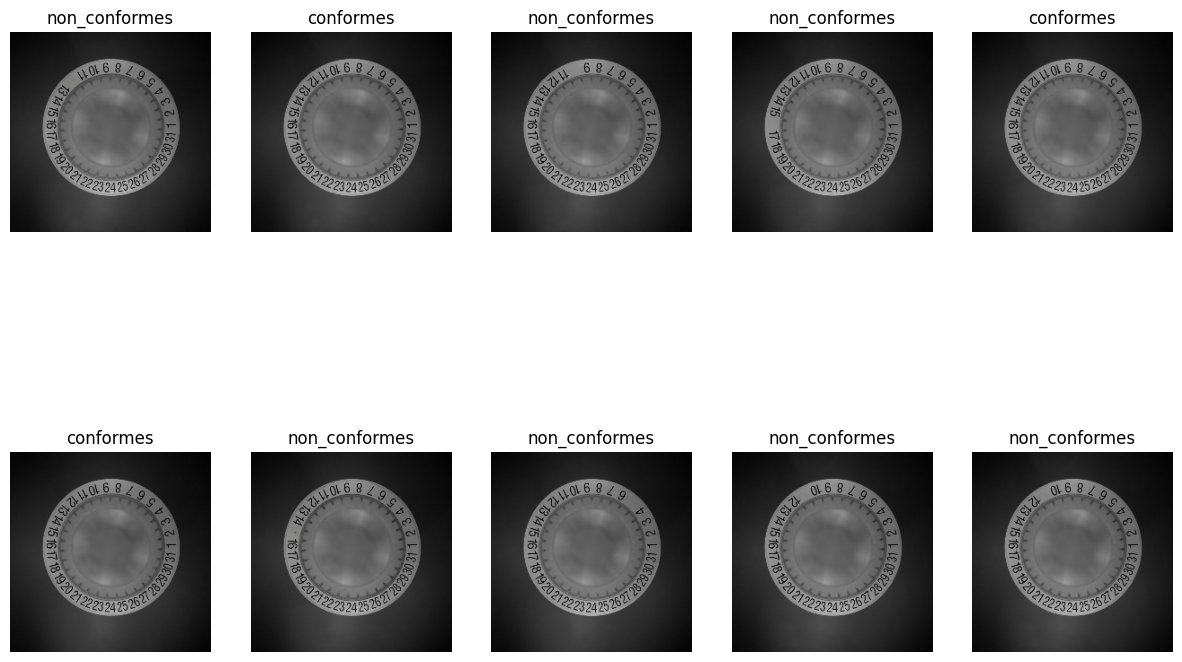

In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
batch_size = 32
img_height = 224
img_width = 224
train_ds = image_dataset_from_directory(
    "data/train",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "data/validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = image_dataset_from_directory(
    "data/test",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


image_batch, label_batch = next(iter(train_ds))

# Sélectionner 10 images aléatoires dans cette batch
indices = np.random.choice(len(image_batch), 10, replace=False)
selected_images = image_batch.numpy()[indices]
selected_labels = label_batch.numpy()[indices]

# Affichage
class_names = train_ds.class_names

plt.figure(figsize=(15, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i].astype("uint8"))
    plt.title(class_names[selected_labels[i]])
    plt.axis("off")
plt.show()

In [3]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binaire
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ➕ Pondération des classes
# 0 = conformes, 1 = non_conformes
weight_for_0 = (1 / 1500) * ((1500 + 2500) / 2.0)
weight_for_1 = (1 / 2500) * ((1500 + 2500) / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}
print("Class weights :", class_weights)

# ⏳ EarlyStopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Entraînement du modèle
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weights
)



Class weights : {0: 1.3333333333333333, 1: 0.8}
Epoch 1/10


118/118 [==============================] - 179s 1s/step - loss: 0.7024 - accuracy: 0.4139 - val_loss: 0.6971 - val_accuracy: 0.4078
Epoch 2/10
118/118 [==============================] - 133s 1s/step - loss: 0.7018 - accuracy: 0.4008 - val_loss: 0.6989 - val_accuracy: 0.4078
Epoch 3/10
118/118 [==============================] - 129s 1s/step - loss: 0.7014 - accuracy: 0.4008 - val_loss: 0.7007 - val_accuracy: 0.4078
Epoch 4/10
118/118 [==============================] - 123s 1s/step - loss: 0.7015 - accuracy: 0.4008 - val_loss: 0.7018 - val_accuracy: 0.4078


In [5]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.2f}")

25/25 [==============================] - 8s 236ms/step - loss: 0.6978 - accuracy: 0.3911
Test accuracy: 0.39


In [6]:
import tensorflow as tf
import numpy as np
import os

# Paramètres
batch_size = 1  # Important : batch=1 pour afficher chaque image individuellement
img_height = 224
img_width = 224

# Chargement du dataset
raw_test_verif_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test_verif",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# Récupération des noms de classes
class_names = raw_test_verif_ds.class_names
print("Classes détectées :", class_names)

# Prétraitement : normalisation
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_verif_ds = raw_test_verif_ds.map(lambda x, y: (normalization_layer(x), y))

# Variables pour le calcul de l'accuracy
total = 0
correct = 0

print("\n🔍 Prédictions individuelles :\n")

# Parcours du dataset image par image
for images, labels in test_verif_ds:
    predictions = model.predict(images)
    
    # Cas de 2 classes : sigmoid (float entre 0 et 1), à arrondir
    if predictions.shape[-1] == 1:
        predicted_labels = tf.round(predictions).numpy().astype(int).flatten()
    else:
        predicted_labels = tf.argmax(predictions, axis=1).numpy()
    
    true_label = labels.numpy().astype(int).flatten()[0]
    predicted_label = predicted_labels[0]

    total += 1
    if predicted_label == true_label:
        correct += 1

    # Récupération du chemin d'image original
    file_path = raw_test_verif_ds.file_paths[total - 1]
    file_name = os.path.basename(file_path)

    print(f"🖼️ {file_name} | Expected: {class_names[true_label]} | Predicted: {class_names[predicted_label]}")

# Calcul final
accuracy = correct / total
print(f"\n✅ Accuracy globale sur test_verif : {accuracy * 100:.2f}%")


Found 10 files belonging to 2 classes.
Classes détectées : ['conformes', 'non_conformes']

🔍 Prédictions individuelles :

1/1 [==============================] - 1s 503ms/step
🖼️ 30mm_WonB_NC_2.bmp | Expected: conformes | Predicted: conformes
1/1 [==============================] - 0s 56ms/step
🖼️ image_19.jpg | Expected: conformes | Predicted: conformes
1/1 [==============================] - 0s 54ms/step
🖼️ image_29.jpg | Expected: conformes | Predicted: conformes
1/1 [==============================] - 0s 56ms/step
🖼️ img_2.bmp | Expected: conformes | Predicted: conformes
1/1 [==============================] - 0s 56ms/step
🖼️ img_4.bmp | Expected: conformes | Predicted: conformes
1/1 [==============================] - 0s 53ms/step
🖼️ img_6.bmp | Expected: conformes | Predicted: conformes
1/1 [==============================] - 0s 50ms/step
🖼️ 30mm_WonB_NC_1.bmp | Expected: non_conformes | Predicted: conformes
1/1 [==============================] - 0s 49ms/step
🖼️ img_1.bmp | Expected: no

## Model version 2 avec pre traitement

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_data, min_height=20, min_width=15, digit_size=(29, 29), max_distance_ratio=0.5, min_area=100, max_aspect_ratio=5, max_compactness=15, show_steps=True):
    # Convertir en niveaux de gris
    img_gray = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)

    # Binarisation adaptative
    img_bin = cv2.adaptiveThreshold(img_gray, 255,
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 21, 10)

    # Trouver les contours
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dessiner les contours pour visualisation
    img_contours = img_data.copy()
    cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

    # Filtrer et regrouper les contours
    grouped_contours = []
    used_contours = [False] * len(contours)
    for i, cnt1 in enumerate(contours):
        if used_contours[i]:
            continue
        x1, y1, w1, h1 = cv2.boundingRect(cnt1)
        area1 = cv2.contourArea(cnt1)
        perimeter1 = cv2.arcLength(cnt1, True)
        aspect_ratio1 = float(w1) / h1 if h1 > 0 else 1.0
        compactness1 = (perimeter1 * perimeter1) / area1 if area1 > 0 else float('inf')

        # Filtrer les lignes et le bruit
        if (h1 < min_height or w1 < min_width or area1 < min_area or
            aspect_ratio1 > max_aspect_ratio or aspect_ratio1 < 1.0/max_aspect_ratio or
            compactness1 > max_compactness):
            continue

        group = [(x1, y1, w1, h1, cnt1)]
        used_contours[i] = True

        for j, cnt2 in enumerate(contours[i+1:], start=i+1):
            if used_contours[j]:
                continue
            x2, y2, w2, h2 = cv2.boundingRect(cnt2)
            area2 = cv2.contourArea(cnt2)
            aspect_ratio2 = float(w2) / h2 if h2 > 0 else 1.0
            compactness2 = (cv2.arcLength(cnt2, True) * cv2.arcLength(cnt2, True)) / area2 if area2 > 0 else float('inf')

            # Filtrer les lignes et le bruit pour cnt2
            if (h2 < min_height or w2 < min_width or area2 < min_area or
                aspect_ratio2 > max_aspect_ratio or aspect_ratio2 < 1.0/max_aspect_ratio or
                compactness2 > max_compactness):
                continue

            # Vérifier l'alignement vertical et la proximité horizontale
            if abs(y1 - y2) < max(h1, h2) and abs(x2 - (x1 + w1)) < max_distance_ratio * max(h1, h2):
                group.append((x2, y2, w2, h2, cnt2))
                used_contours[j] = True

        if group:
            # Calculer les coordonnées globales du groupe
            x_min = min(x for x, _, _, _, _ in group)
            y_min = min(y for _, y, _, _, _ in group)
            x_max = max(x + w for x, _, w, _, _ in group)
            y_max = max(y + h for _, y, _, h, _ in group)
            w_group = x_max - x_min
            h_group = y_max - y_min
            if h_group > min_height and w_group > min_width:
                grouped_contours.append((x_min, y_min, w_group, h_group, group))

    # Extraire les digits regroupés
    extracted_digits = []
    for x, y, w, h, group in grouped_contours:
        digit = img_bin[y:y+h, x:x+w]
        # Ajouter un padding pour centrer le digit
        pad_h = max(0, (digit_size[1] - h) // 2)
        pad_w = max(0, (digit_size[0] - w) // 2)
        digit_padded = cv2.copyMakeBorder(digit, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=0)
        # Redimensionner à la taille cible
        digit_resized = cv2.resize(digit_padded, digit_size, interpolation=cv2.INTER_AREA)
        extracted_digits.append(digit_resized)

    # Sauvegarder les étapes si demandé
    if show_steps:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title('Grayscale')
        plt.subplot(1, 3, 2)
        plt.imshow(img_bin, cmap='gray')
        plt.title('Binarized')
        plt.subplot(1, 3, 3)
        plt.imshow(img_contours)
        plt.title('Contours')
        plt.savefig('preprocessing_steps.png')
        plt.close()

    return extracted_digits

# Exemple d'utilisation (à adapter selon l'environnement) :
# img_data = np.array(...)  # Remplacer par un tableau NumPy représentant l'image
# digits = preprocess_image(img_data)
# print(digits)

In [36]:
# === Lancer le traitement ===
process_dataset(input_root, output_root)
print("✅ Traitement terminé, les images binarisées sont prêtes dans :", output_root)

✅ Traitement terminé, les images binarisées sont prêtes dans : dataset_binarized


## test dans une image

### Binarisation sur une seule image 

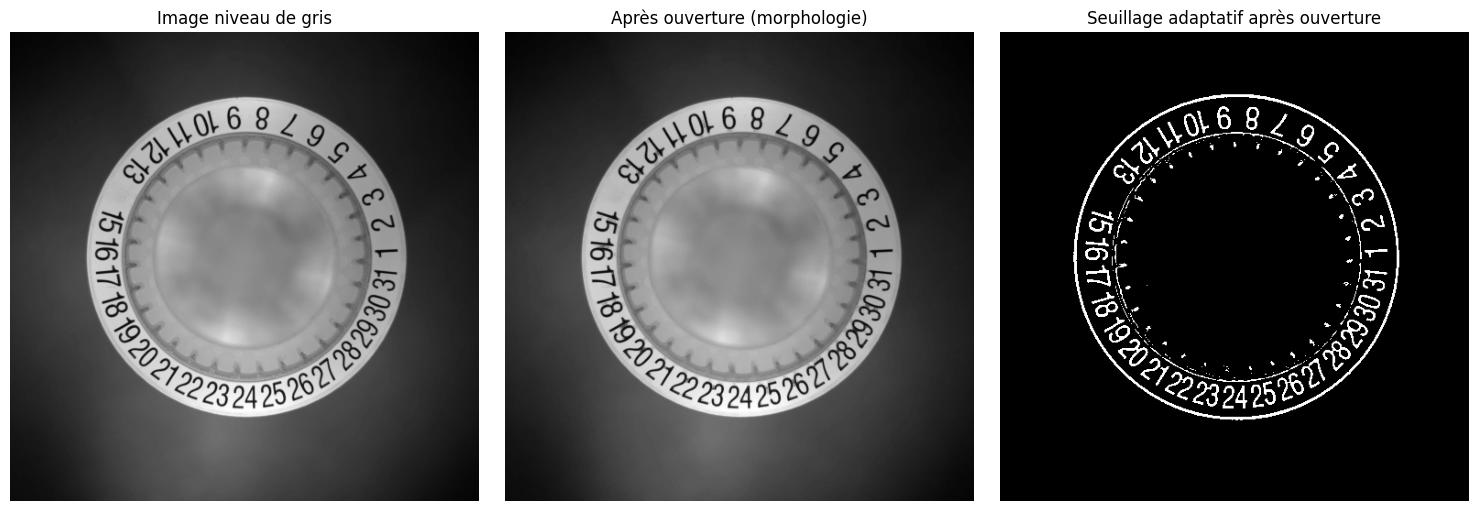

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image
image_path = "data/train/non_conformes/image_451.jpg"
image = cv2.imread(image_path)

# Réduction à 128x128 pixels (redimensionnement forcé)
image_resized = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)

# Conversion en niveaux de gris
gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

# Morphologie : ouverture pour supprimer petits bruits (petits traits)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel, iterations=1)

# Seuillage adaptatif sur l'image ouverte
adaptive_thresh = cv2.adaptiveThreshold(
    opened, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    blockSize=15,
    C=10
)

# Affichage des étapes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(gray, cmap='gray')
axs[0].set_title("Image niveau de gris")
axs[0].axis('off')

axs[1].imshow(opened, cmap='gray')
axs[1].set_title("Après ouverture (morphologie)")
axs[1].axis('off')

axs[2].imshow(adaptive_thresh, cmap='gray')
axs[2].set_title("Seuillage adaptatif après ouverture")
axs[2].axis('off')

plt.tight_layout()
plt.show()


### Creation du dataset

In [87]:
import cv2
import os
import numpy as np
from tqdm import tqdm

def process_image(image_path):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel, iterations=1)

    adaptive_thresh = cv2.adaptiveThreshold(
        opened, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=15,
        C=10
    )

    contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features_list = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 110:
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = w / float(h)
            if 0.2 < aspect_ratio < 1.2:
                roi = adaptive_thresh[y:y+h, x:x+w]
                roi_resized = cv2.resize(roi, (28, 28))
                features = roi_resized.flatten()
                features_list.append(features)

    return features_list

def create_dataset(base_path):
    features_all = []
    labels_all = []
    classes = {"non_conformes": 0, "conformes": 1}

    for dataset_type in ["train", "test", "validation"]:
        dataset_path = os.path.join(base_path, dataset_type)
        if not os.path.exists(dataset_path):
            print(f"⚠️ Dossier {dataset_type} absent, on passe.")
            continue

        for cls in classes:
            folder = os.path.join(dataset_path, cls)
            if not os.path.exists(folder):
                print(f"⚠️ Dossier {folder} absent, on passe.")
                continue

            print(f"Traitement {dataset_type}/{cls}...")
            for filename in tqdm(os.listdir(folder)):
                if filename.lower().endswith((".jpg", ".png", ".jpeg")):
                    img_path = os.path.join(folder, filename)
                    features_list = process_image(img_path)
                    for feat in features_list:
                        features_all.append(feat)
                        labels_all.append(classes[cls])

    X = np.array(features_all)
    y = np.array(labels_all)
    print(f"\n✅ Dataset créé avec {len(X)} échantillons.")

    return X, y

if __name__ == "__main__":
    base_path = "data"  # adapte selon ta structure locale

    X, y = create_dataset(base_path)

    # Sauvegarde en .npz
    np.savez_compressed("dataset_chiffres.npz", X=X, y=y)
    print("✅ Dataset sauvegardé sous 'dataset_chiffres.npz'")
    print("🔢 X shape :", X.shape)

Traitement train/non_conformes...


100%|██████████| 2244/2244 [01:51<00:00, 20.21it/s]


Traitement train/conformes...


100%|██████████| 1501/1501 [01:08<00:00, 21.93it/s]


Traitement test/non_conformes...


100%|██████████| 481/481 [00:23<00:00, 20.60it/s]


Traitement test/conformes...


100%|██████████| 309/309 [00:13<00:00, 22.22it/s]


Traitement validation/non_conformes...


100%|██████████| 456/456 [00:21<00:00, 20.88it/s]


Traitement validation/conformes...


100%|██████████| 314/314 [00:16<00:00, 19.26it/s]



✅ Dataset créé avec 5305 échantillons.
✅ Dataset sauvegardé sous 'dataset_chiffres.npz'
🔢 X shape : (5305, 784)


## Création du model 

In [14]:
import numpy as np

data = np.load("dataset_chiffres.npz")

X = data['X']
y = data['y']

# Mélanger les données (features et labels ensemble)
indices = np.arange(len(X))
np.random.shuffle(indices)

X_shuffled = X[indices]
y_shuffled = y[indices]

print("Taille de X :", X.shape)
print("Taille de y :", y.shape)


#print nombre d elment par classe
unique, counts = np.unique(y_shuffled, return_counts=True)
print("Distribution des classes :")
for label, count in zip(unique, counts):
    print(f"Classe {label}: {count} échantillons")




Taille de X : (5305, 784)
Taille de y : (5305,)
Distribution des classes :
Classe 0: 3181 échantillons
Classe 1: 2124 échantillons


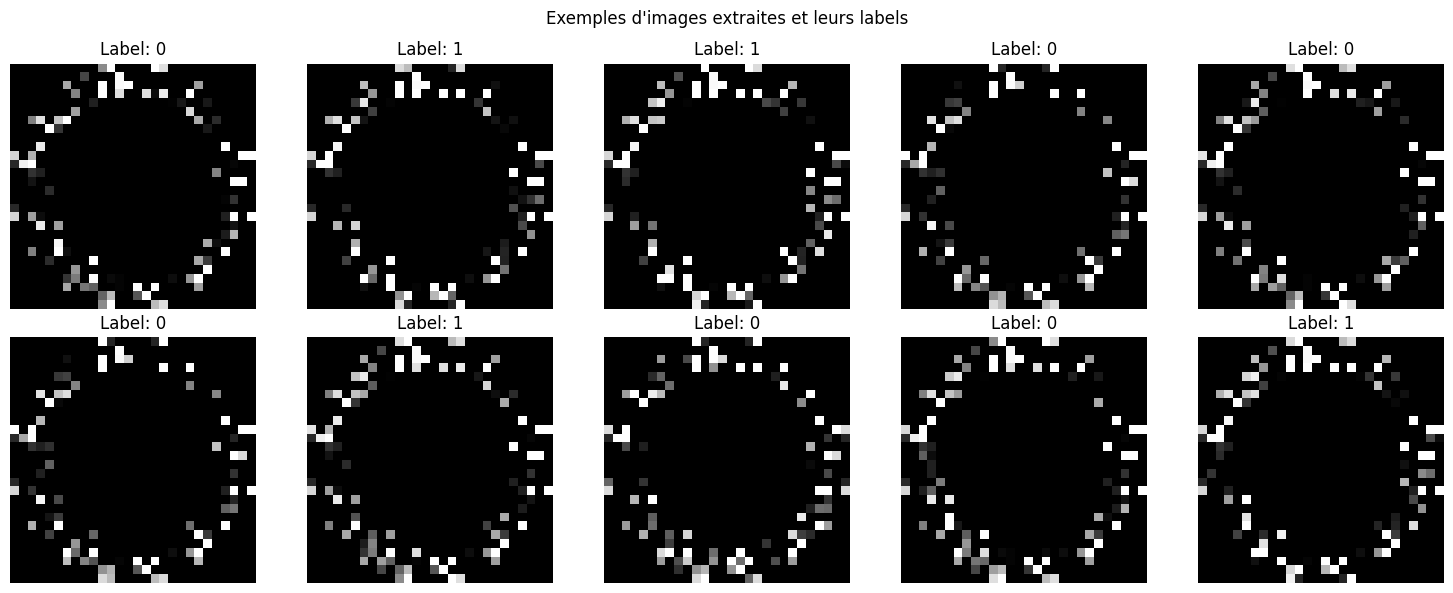

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import random
# Choisir 10 indices aléatoires sans remplacement
indices = random.sample(range(len(X)), 10)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(indices):
    image = X[idx].reshape(28, 28)  # reconstruire l'image 28x28
    label = y[idx]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.suptitle("Exemples d'images extraites et leurs labels")
plt.tight_layout()
plt.show()

## CNN sur image 

Found 3745 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Found 790 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       73856  

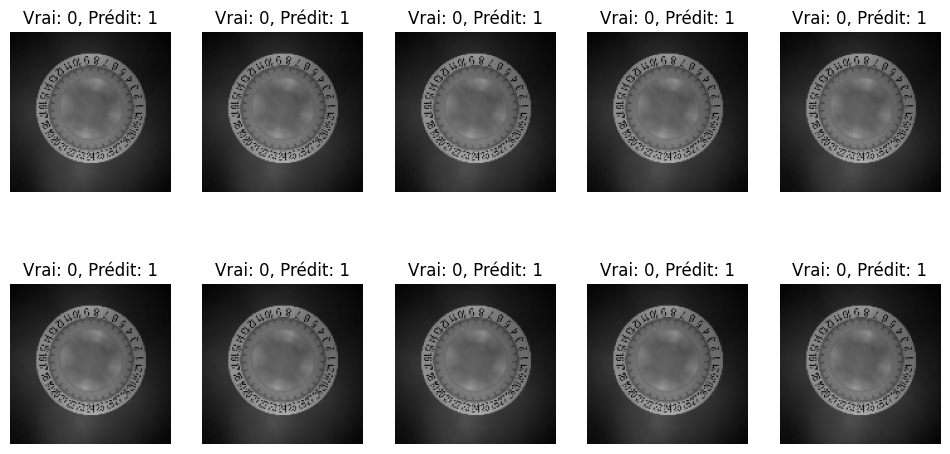

In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Chemin vers le dossier contenant train, test, validation
base_dir = "data"  # adapte selon ta structure

# Paramètres
img_height, img_width = 128, 128  # réduit taille pour accélérer l'entraînement (512 peut être trop grand)
batch_size = 32
num_classes = 2

# Data augmentation + preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

# Chargement des données avec flow_from_directory
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # binaire : conformes / non conformes
    shuffle=True
)

validation_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Construction du modèle CNN simple
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # sortie binaire
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Callback early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stop]
)

# Évaluation sur le test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest accuracy: {test_acc:.4f}")

# Optionnel : Afficher des prédictions sur quelques images test
import matplotlib.pyplot as plt

test_generator.reset()
x_test, y_test = next(test_generator)
preds = model.predict(x_test)
pred_labels = (preds > 0.5).astype(int).flatten()

plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i])
    plt.title(f"Vrai: {int(y_test[i])}, Prédit: {pred_labels[i]}")
    plt.axis('off')
plt.show()


## Capsule Network

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# ----------- Chargement et préparation des données -----------

data = np.load('dataset_chiffres.npz')
X = data['X']   # (5305, 784)
y = data['y']   # (5305,)

# Reshape images en 28x28x1 + normalisation
X = X.reshape(-1, 28, 28, 1).astype('float32') / 255.

# One-hot encoding des labels
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=num_classes)

# ----------- Définition des couches Capsule -----------

class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), axis=-1) + 1e-9)

def squash(vectors, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + 1e-9)
    return scale * vectors

class PrimaryCapsule(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, kernel_size, strides, padding, **kwargs):
        super(PrimaryCapsule, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.conv = layers.Conv2D(filters=num_capsules*dim_capsule,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  padding=padding)
    def call(self, inputs, **kwargs):
        output = self.conv(inputs)
        outputs = tf.reshape(output, (-1, output.shape[1]*output.shape[2]*self.num_capsules, self.dim_capsule))
        return squash(outputs)

class DigitCapsule(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super(DigitCapsule, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        self.W = self.add_weight(shape=(1, self.input_num_capsules, self.num_capsules,
                                        self.dim_capsule, self.input_dim_capsule),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name='W')

    def call(self, inputs, **kwargs):
        batch_size = tf.shape(inputs)[0]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 2), 2)
        inputs_expand = tf.tile(inputs_expand, [1, 1, self.num_capsules, 1, 1])
        W_tiled = tf.tile(self.W, [batch_size, 1, 1, 1, 1])
        u_hat = tf.matmul(W_tiled, inputs_expand, transpose_b=True)
        u_hat = tf.squeeze(u_hat, -1)

        b = tf.zeros(shape=[batch_size, self.input_num_capsules, self.num_capsules])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            c_expanded = tf.expand_dims(c, -1)
            s = tf.reduce_sum(c_expanded * u_hat, axis=1)
            v = squash(s)
            if i < self.routings - 1:
                v_expanded = tf.expand_dims(v, 1)
                b += tf.reduce_sum(u_hat * v_expanded, axis=-1)
        return v

# ----------- Fonction de perte margin loss (CapsNet) -----------

def margin_loss(y_true, y_pred):
    m_plus = 0.9
    m_minus = 0.1
    lambda_ = 0.5
    L = y_true * tf.square(tf.maximum(0., m_plus - y_pred)) + \
        lambda_ * (1 - y_true) * tf.square(tf.maximum(0., y_pred - m_minus))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

# ----------- Création du modèle CapsNet -----------

def create_capsnet(input_shape=(28,28,1), num_classes=num_classes):
    inputs = layers.Input(shape=input_shape)

    # Couche conv classique
    x = layers.Conv2D(filters=256, kernel_size=9, strides=1, activation='relu')(inputs)

    # Couche PrimaryCapsule
    primary_caps = PrimaryCapsule(num_capsules=8, dim_capsule=16, kernel_size=9, strides=2, padding='valid')(x)

    # Couche DigitCapsule
    digit_caps = DigitCapsule(num_capsules=num_classes, dim_capsule=16, routings=3)(primary_caps)

    # Longueur des capsules → prédiction finale
    outputs = Length()(digit_caps)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# ----------- Instanciation et compilation -----------

model = create_capsnet()
model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

# ----------- Entraînement -----------

model.fit(X, y_cat, batch_size=64, epochs=4, validation_split=0.2)

# ----------- Évaluation -----------

loss, acc = model.evaluate(X, y_cat)
print(f"Loss: {loss:.4f} | Accuracy: {acc:.4f}")


Epoch 1/4
67/67 [==============================] - 42s 575ms/step - loss: 0.4546 - accuracy: 0.5273 - val_loss: 0.2125 - val_accuracy: 0.5702
Epoch 2/4
67/67 [==============================] - 35s 528ms/step - loss: 0.1893 - accuracy: 0.6706 - val_loss: 0.2369 - val_accuracy: 0.6352
Epoch 3/4
67/67 [==============================] - 35s 523ms/step - loss: 0.1058 - accuracy: 0.8478 - val_loss: 0.0904 - val_accuracy: 0.8030
Epoch 4/4
166/166 [==============================] - 13s 77ms/step - loss: 0.0084 - accuracy: 1.0000
Loss: 0.0084 | Accuracy: 1.0000


In [37]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model

# ----------- Redéfinir la loss si nécessaire -----------
def margin_loss(y_true, y_pred):
    m_plus = 0.9
    m_minus = 0.1
    lambda_ = 0.5
    L = y_true * tf.square(tf.maximum(0., m_plus - y_pred)) + \
        lambda_ * (1 - y_true) * tf.square(tf.maximum(0., y_pred - m_minus))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

# ----------- Charger le modèle -----------


# ----------- Fonction de traitement ROI -----------

def extract_roi(image):
    """Convertit l'image en ROI similaire à celles du dataset initial"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Plus grand contour = ROI principale
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        roi = gray[y:y+h, x:x+w]
    else:
        roi = gray  # fallback si pas de contours

    roi_resized = cv2.resize(roi, (28, 28))
    roi_normalized = roi_resized.astype('float32') / 255.0
    roi_normalized = roi_normalized.reshape(1, 28, 28, 1)
    return roi_normalized

# ----------- Fonction de prédiction ------------

def predict_folder_with_roi(folder_path):
    for label in os.listdir(folder_path):
        subfolder = os.path.join(folder_path, label)
        if not os.path.isdir(subfolder):
            continue
        print(f"\n📁 Catégorie : {label}")
        for filename in os.listdir(subfolder):
            filepath = os.path.join(subfolder, filename)
            image = cv2.imread(filepath)
            if image is None:
                print(f"⚠️ Image non lue : {filename}")
                continue
            roi = extract_roi(image)
            pred = model.predict(roi)
            predicted_class = np.argmax(pred)
            confidence = np.max(pred)
            print(f"{filename} ➤ Prédit : {predicted_class} (Confiance : {confidence:.2f})")

# ----------- Lancer la prédiction -----------
predict_folder_with_roi("data/test_verif")



📁 Catégorie : conformes


1/1 [==============================] - 0s 62ms/step
30mm_WonB_NC_2.png ➤ Prédit : 0 (Confiance : 0.00)
1/1 [==============================] - 0s 73ms/step
image_19.jpg ➤ Prédit : 0 (Confiance : 0.00)
1/1 [==============================] - 0s 56ms/step
image_29.jpg ➤ Prédit : 0 (Confiance : 0.00)
1/1 [==============================] - 0s 59ms/step
img_2.png ➤ Prédit : 0 (Confiance : 0.00)
1/1 [==============================] - 0s 50ms/step
img_4.png ➤ Prédit : 0 (Confiance : 0.00)
1/1 [==============================] - 0s 56ms/step
img_6.png ➤ Prédit : 0 (Confiance : 0.00)

📁 Catégorie : non_conformes
1/1 [==============================] - 0s 50ms/step
30mm_WonB_NC_1.png ➤ Prédit : 0 (Confiance : 0.00)
1/1 [==============================] - 0s 63ms/step
img_1.png ➤ Prédit : 0 (Confiance : 0.00)
1/1 [==============================] - 0s 51ms/step
img_3.png ➤ Prédit : 0 (Confiance : 0.00)
1/1 [==============================] - 0s 55ms/step
img_5.png ➤ Prédit : 0 (Confiance : 0.00)


## Utilisation du dataset minst

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Charger MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Préparer les données
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Créer le modèle CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(x_train, y_train, epochs=5, batch_size=64,
                    validation_data=(x_test, y_test), verbose=1)

# Évaluer le modèle
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Précision sur MNIST : {test_accuracy:.2%}")

# Sauvegarder le modèle
model.save('mnist_base_model.h5')
print("Modèle sauvegardé sous 'mnist_base_model.h5'")

11490434/11490434 [==============================] - 3s 0us/step
Epoch 1/5
938/938 [==============================] - 24s 23ms/step - loss: 0.2324 - accuracy: 0.9302 - val_loss: 0.0503 - val_accuracy: 0.9837
Epoch 2/5
938/938 [==============================] - 20s 22ms/step - loss: 0.0793 - accuracy: 0.9764 - val_loss: 0.0354 - val_accuracy: 0.9880
Epoch 3/5
938/938 [==============================] - 26s 28ms/step - loss: 0.0581 - accuracy: 0.9830 - val_loss: 0.0309 - val_accuracy: 0.9895
Epoch 4/5
938/938 [==============================] - 22s 23ms/step - loss: 0.0475 - accuracy: 0.9856 - val_loss: 0.0256 - val_accuracy: 0.9902
Epoch 5/5
313/313 [==============================] - 3s 8ms/step - loss: 0.0243 - accuracy: 0.9919
Précision sur MNIST : 99.19%


c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modèle sauvegardé sous 'mnist_base_model.h5'


In [6]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# Charger le modèle une seule fois au niveau global
model = load_model('mnist_base_model.h5')

def predict_digit_from_image(image_path):
    """
    Prédit le chiffre sur une image binarisée (fond blanc, chiffre noir).
    :param image_path: chemin vers l'image
    :return: chiffre prédit (int)
    """
    # Charger et convertir l'image en niveaux de gris
    img = Image.open(image_path).convert('L')
    
    # Redimensionner à 28x28
    img = img.resize((28, 28))

    # Convertir en tableau numpy et normaliser
    img_array = np.array(img).astype('float32') / 255.0

    # Formater pour le modèle (1, 28, 28, 1)
    img_array = img_array.reshape(1, 28, 28, 1)

    # Prédire
    prediction = model.predict(img_array, verbose=0)
    predicted_digit = int(np.argmax(prediction))

    return predicted_digit

chemin_image = "image.png"
chiffre = predict_digit_from_image(chemin_image)
print(f"Chiffre prédit : {chiffre}")


Chiffre prédit : 6


### detection et extraction des positions

In [1]:
import cv2
import json

positions = []

# Callback pour gérer les clics souris
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        w, h = 28, 28  # Taille du ROI
        positions.append((x, y, w, h))
        print(f"Position enregistrée : x={x}, y={y}, w={w}, h={h}")
        cv2.rectangle(img_display, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imshow(window_name, img_display)

# --- Charge l'image binarisée du décalque ---
image_path = "dataset_binarized/train/conformes/30mm_WonB_1_resized_copy1_copy1_copy1.jpg"
img = cv2.imread(image_path)

if img is None:
    raise FileNotFoundError(f"L'image '{image_path}' n'a pas été trouvée.")

img_display = img.copy()

# --- Crée une fenêtre redimensionnable ---
window_name = "Clique sur les chiffres"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.imshow(window_name, img_display)
cv2.setMouseCallback(window_name, click_event)

print("🖱️ Clique sur chaque chiffre à extraire (ROI 28x28).")
print("❌ Appuie sur 'q' pour terminer et fermer.")

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

# --- Sauvegarde les positions dans un fichier JSON ---
with open("positions_chiffres.json", "w") as f:
    json.dump(positions, f)

print("✅ Positions sauvegardées dans 'positions_chiffres.json'")


🖱️ Clique sur chaque chiffre à extraire (ROI 28x28).
❌ Appuie sur 'q' pour terminer et fermer.
Position enregistrée : x=1203, y=414, w=28, h=28
Position enregistrée : x=1338, y=443, w=28, h=28
Position enregistrée : x=1461, y=520, w=28, h=28
Position enregistrée : x=1577, y=588, w=28, h=28
Position enregistrée : x=1677, y=659, w=28, h=28


KeyboardInterrupt: 

### Preparation des données 

In [ ]:
import cv2
import os
from pathlib import Path

# === PARAMÈTRES ===
input_folder = "dataset_binarized/train/non_conformes"        # Dossier avec tes images
output_folder = "roi_images"       # Dossier où les ROI seront enregistrés
coords_file = "coords.txt"     # Fichier avec les coordonnées des ROI
roi_size = (28, 28)            # Taille cible (optionnel : resize si nécessaire)

# === CRÉATION DES DOSSIERS OUTPUT ===
Path(output_folder).mkdir(parents=True, exist_ok=True)

# === LECTURE DES COORDONNÉES ===
with open(coords_file, "r") as f:
    coords = [tuple(map(int, line.strip().split(","))) for line in f]

# === TRAITEMENT DES IMAGES ===
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

for img_index, img_name in enumerate(image_files):
    img_path = os.path.join(input_folder, img_name)
    image = cv2.imread(img_path)

    if image is None:
        print(f"[❌] Image non chargée : {img_name}")
        continue

    for i, (x, y, w, h) in enumerate(coords):
        roi = image[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi, roi_size)

        # Création d’un nom de fichier : imageIndex_roiIndex.jpg
        roi_filename = f"{Path(img_name).stem}_roi{i:02}.jpg"
        roi_path = os.path.join(output_folder, roi_filename)

        cv2.imwrite(roi_path, roi_resized)

    print(f"[✅] {img_name} → {len(coords)} ROI extraits")

print("\nExtraction terminée. Vérifie le dossier 'output'.")


### Labelisation des images 

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import os
import shutil
from pathlib import Path

# === PARAMÈTRES ===
roi_folder = "roi_images"  # Dossier contenant les ROI à trier
conforme_folder = os.path.join(roi_folder, "conforme")
non_conforme_folder = os.path.join(roi_folder, "non_conforme")

# === CRÉATION DES DOSSIERS DE CLASSEMENT ===
Path(conforme_folder).mkdir(parents=True, exist_ok=True)
Path(non_conforme_folder).mkdir(parents=True, exist_ok=True)

# === LISTE DES IMAGES À TRIER ===
images = [f for f in os.listdir(roi_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# === INTERFACE ===
class TriROI:
    def __init__(self, master):
        self.master = master
        self.master.title("Interface de tri des ROI")
        self.index = 0
        self.image_label = tk.Label(master)
        self.image_label.pack()

        # Boutons
        btn_frame = tk.Frame(master)
        btn_frame.pack(pady=10)

        btn_c = tk.Button(btn_frame, text="✅ Conforme (C)", command=self.mark_conforme, width=20)
        btn_nc = tk.Button(btn_frame, text="❌ Non Conforme (N)", command=self.mark_non_conforme, width=20)
        btn_c.pack(side=tk.LEFT, padx=10)
        btn_nc.pack(side=tk.RIGHT, padx=10)

        # Raccourcis clavier
        master.bind("<c>", lambda e: self.mark_conforme())
        master.bind("<n>", lambda e: self.mark_non_conforme())

        self.show_image()

    def show_image(self):
        if self.index >= len(images):
            self.image_label.config(text="🎉 Tri terminé.")
            return

        img_path = os.path.join(roi_folder, images[self.index])
        image = Image.open(img_path)
        image = image.resize((200, 200))  # Resize pour affichage
        self.photo = ImageTk.PhotoImage(image)

        self.image_label.config(image=self.photo)
        self.image_label.image = self.photo

    def move_image(self, destination_folder):
        src = os.path.join(roi_folder, images[self.index])
        dst = os.path.join(destination_folder, images[self.index])
        shutil.move(src, dst)
        self.index += 1
        self.show_image()

    def mark_conforme(self):
        self.move_image(conforme_folder)

    def mark_non_conforme(self):
        self.move_image(non_conforme_folder)

# === LANCEMENT ===
if __name__ == "__main__":
    root = tk.Tk()
    app = TriROI(root)
    root.mainloop()


### Entrainement du model pour détecter un chiffre manquant

Epoch 1/10
38/38 [==============================] - 4s 33ms/step - loss: 0.1434 - accuracy: 0.9073 - val_loss: 0.0757 - val_accuracy: 0.9933
Epoch 2/10
38/38 [==============================] - 1s 21ms/step - loss: 0.0442 - accuracy: 0.9925 - val_loss: 0.0389 - val_accuracy: 0.9933
Epoch 3/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0280 - accuracy: 0.9967 - val_loss: 0.0424 - val_accuracy: 0.9933
Epoch 4/10
38/38 [==============================] - 1s 23ms/step - loss: 0.0202 - accuracy: 0.9967 - val_loss: 0.0469 - val_accuracy: 0.9933
Epoch 5/10
38/38 [==============================] - 1s 20ms/step - loss: 0.0182 - accuracy: 0.9967 - val_loss: 0.0522 - val_accuracy: 0.9933
Epoch 6/10
38/38 [==============================] - 1s 20ms/step - loss: 0.0177 - accuracy: 0.9967 - val_loss: 0.0537 - val_accuracy: 0.9933
Epoch 7/10
38/38 [==============================] - 1s 18ms/step - loss: 0.0194 - accuracy: 0.9967 - val_loss: 0.0572 - val_accuracy: 0.9933
Epoch 8/10
38

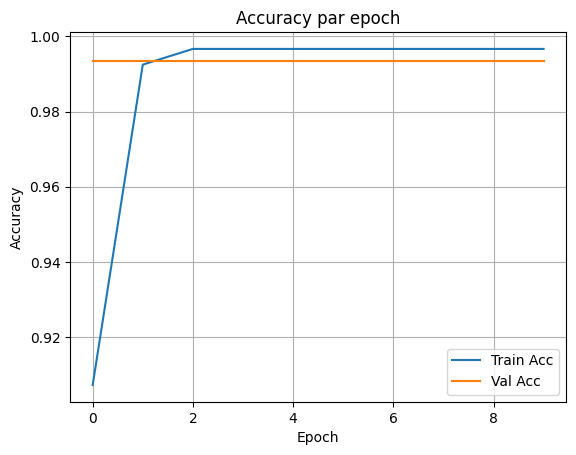

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# === PARAMÈTRES ===
img_size = 28
dataset_path = "roi_images"
classes = ["conforme", "non_conforme"]

# === CHARGEMENT DES IMAGES ===
X = []
y = []

for idx, label in enumerate(classes):
    class_folder = os.path.join(dataset_path, label)
    for file in os.listdir(class_folder):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(class_folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(idx)

X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.0  # Normalisation
y = to_categorical(y, num_classes=2)

# === DIVISION TRAIN/TEST ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === MODELE CNN SIMPLE ===
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes
])

# === COMPILATION ===
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# === ENTRAINEMENT ===
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# === EVALUATION ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.2%}")
model.save("cnn_conformite_model.h5")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy par epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Extraction des roi en vue de test v1

In [63]:
import cv2
import os

# Chemin de l'image et du dossier de sortie
image_path = "dataset_binarized/train/conformes/30mm_WonB_1_resized_copy1_copy1_copy1.jpg"
output_dir = "extracted_rois"
coord_file = "coords.txt"

# Créer le dossier de sortie s'il n'existe pas
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lire les coordonnées depuis le fichier
positions = []
with open(coord_file, 'r') as file:
    for line in file:
        values = line.strip().split(',')
        if len(values) == 4:
            x, y, w, h = map(int, values)
            positions.append((x, y, w, h))

# Charger l'image
image = cv2.imread(image_path)
if image is None:
    print("Erreur : Impossible de charger l'image.")
    exit()

# Extraire et sauvegarder les ROI
for idx, (x, y, w, h) in enumerate(positions):
    x_start = max(0, x)
    y_start = max(0, y)
    x_end = min(image.shape[1], x + w)
    y_end = min(image.shape[0], y + h)
    if x_end > x_start and y_end > y_start:
        roi = image[y_start:y_end, x_start:x_end]
        output_filename = f"roi_{idx+1}.png"
        output_path = os.path.join(output_dir, output_filename)
        cv2.imwrite(output_path, roi)
        print(f"ROI {idx+1} sauvegardée : {output_path}")

ROI 1 sauvegardée : extracted_rois\roi_1.png
ROI 2 sauvegardée : extracted_rois\roi_2.png
ROI 3 sauvegardée : extracted_rois\roi_3.png
ROI 4 sauvegardée : extracted_rois\roi_4.png
ROI 5 sauvegardée : extracted_rois\roi_5.png
ROI 6 sauvegardée : extracted_rois\roi_6.png
ROI 7 sauvegardée : extracted_rois\roi_7.png
ROI 8 sauvegardée : extracted_rois\roi_8.png
ROI 9 sauvegardée : extracted_rois\roi_9.png
ROI 10 sauvegardée : extracted_rois\roi_10.png
ROI 11 sauvegardée : extracted_rois\roi_11.png
ROI 12 sauvegardée : extracted_rois\roi_12.png
ROI 13 sauvegardée : extracted_rois\roi_13.png
ROI 14 sauvegardée : extracted_rois\roi_14.png
ROI 15 sauvegardée : extracted_rois\roi_15.png
ROI 16 sauvegardée : extracted_rois\roi_16.png
ROI 17 sauvegardée : extracted_rois\roi_17.png
ROI 18 sauvegardée : extracted_rois\roi_18.png
ROI 19 sauvegardée : extracted_rois\roi_19.png
ROI 20 sauvegardée : extracted_rois\roi_20.png
ROI 21 sauvegardée : extracted_rois\roi_21.png
ROI 22 sauvegardée : extracted_

### Test du model

In [59]:
import os
import sys
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# === PARAMÈTRES ===
IMG_SIZE = 28
MODEL_PATH = "cnn_conformite_model.h5"
CLASS_NAMES = ["conforme", "non_conforme"]

def load_and_prepare_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    return img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

def main(folder_path):
    # Charger le modèle
    model = load_model(MODEL_PATH)

    # Parcourir toutes les images
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(folder_path, filename)
            img_input = load_and_prepare_image(filepath)

            if img_input is None:
                print(f"{filename} : image non valide")
                continue

            prediction = model.predict(img_input, verbose=0)
            class_index = np.argmax(prediction)
            confidence = prediction[0][class_index]

            if CLASS_NAMES[class_index] == "non_conforme" and confidence < 0.9:

                print(f"{filename} ➤ {CLASS_NAMES[class_index]} ({confidence:.2%}) ⚠️")
            else : 
                print(f"{filename} ➤ {CLASS_NAMES[class_index]} ({confidence:.2%}) ")

folder_path = "extracted_rois"
if os.path.isdir(folder_path):
    main(folder_path)
else:
    print("Erreur : le dossier n'existe pas.")
        


roi_01.png ➤ conforme (100.00%) 
roi_02.png ➤ conforme (100.00%) 
roi_03.png ➤ conforme (99.79%) 
roi_04.png ➤ conforme (100.00%) 
roi_05.png ➤ non_conforme (58.60%) ⚠️
roi_06.png ➤ conforme (100.00%) 
roi_07.png ➤ conforme (99.99%) 
roi_08.png ➤ conforme (100.00%) 
roi_09.png ➤ non_conforme (95.09%) 
roi_10.png ➤ conforme (100.00%) 
roi_11.png ➤ conforme (100.00%) 
roi_12.png ➤ conforme (100.00%) 
roi_13.png ➤ conforme (100.00%) 
roi_14.png ➤ non_conforme (99.92%) 
roi_15.png ➤ conforme (100.00%) 
roi_16.png ➤ conforme (100.00%) 
roi_17.png ➤ conforme (100.00%) 
roi_18.png ➤ conforme (100.00%) 
roi_19.png ➤ conforme (100.00%) 
roi_20.png ➤ conforme (99.99%) 
roi_21.png ➤ conforme (100.00%) 
roi_22.png ➤ conforme (100.00%) 
roi_23.png ➤ conforme (100.00%) 
roi_24.png ➤ conforme (98.55%) 
roi_25.png ➤ conforme (100.00%) 
roi_26.png ➤ conforme (99.99%) 
roi_27.png ➤ conforme (100.00%) 
roi_28.png ➤ conforme (99.98%) 
roi_29.png ➤ conforme (100.00%) 
roi_30.png ➤ conforme (100.00%) 
roi_3

### Binarisé une image 

In [ ]:
import cv2
import os
import numpy as np



def binarize_image(input_image_path, output_image_path):
    if not os.path.exists(input_image_path):
        print(f"Erreur : L'image d'entrée {input_image_path} n'existe pas.")
        exit()
    img = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Erreur : Impossible de charger l'image à {input_image_path}")
        exit()

    thresh_adaptive = cv2.adaptiveThreshold(
        img, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  
        cv2.THRESH_BINARY_INV,          
        11,                             
        2                               
    )
    _, thresh_otsu = cv2.threshold(
        img, 0, 255, 
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU  
    )

    thresh = thresh_adaptive
    cv2.imwrite(output_image_path, thresh)
    print(f"Image binarisée sauvegardée sous {output_image_path}")

    # Afficher l'image originale et l'image binarisée pour vérification
    cv2.imshow("Image originale (niveaux de gris)", img)
    cv2.imshow("Image binarisée", thresh)
    cv2.waitKey(0)  
    cv2.destroyAllWindows()


# Chemin de l'image d'entrée
input_image_path = "chiffre.jpg"
# Chemin pour sauvegarder l'image binarisée
output_image_path = "binarized_image.jpg"
binarize_image(input_image_path, output_image_path)

Image binarisée sauvegardée sous binarized_image.jpg


# Model de prédiction du chiffre manquant 

### Pré -traitrements : détection des positions des chiffres depuis une image provenant d un dxf 


In [ ]:
'data/dxf/dxf_clean_grand.png'

In [28]:
import cv2
import numpy as np

# Variable globale pour stocker les positions des clics
positions = []
rectangles = []  # Liste pour stocker les rectangles (début et fin)
drawing = False  # Indicateur de dessin
start_point = None  # Point de départ du rectangle

# Fonction de gestion des clics
def draw_rectangle(event, x, y, flags, param):
    global start_point, drawing, positions, rectangles, image

    if event == cv2.EVENT_LBUTTONDOWN:
        # Début du dessin
        drawing = True
        start_point = (x, y)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            # Mettre à jour l'image temporairement pour montrer le rectangle en cours
            temp_image = image.copy()
            cv2.rectangle(temp_image, start_point, (x, y), (0, 255, 0), 2)
            cv2.imshow('Image', temp_image)

    elif event == cv2.EVENT_LBUTTONUP:
        # Fin du dessin
        drawing = False
        end_point = (x, y)
        rectangles.append((start_point, end_point))

        # Calculer le centre du rectangle
        center_x = (start_point[0] + end_point[0]) // 2
        center_y = (start_point[1] + end_point[1]) // 2
        positions.append((center_x, center_y))

        # Dessiner le rectangle sur l'image principale
        cv2.rectangle(image, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Image', image)

        # Afficher les coordonnées dans la console
        print(f"Position {len(positions)}: (x={center_x}, y={center_y})")

# Charger l'image
image_path = 'image_rotated/30mm_WonB_5_resized.jpg'  # Remplacez par le chemin de votre image
image = cv2.imread(image_path)

# Vérifier si l'image est bien chargée
if image is None:
    print("Erreur : Impossible de charger l'image. Vérifiez le chemin.")
    exit()

# Convertir l'image en couleur si elle est en niveaux de gris
if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Obtenir les dimensions de l'image
h, w = image.shape[:2]

# Créer une fenêtre redimensionnable
cv2.namedWindow('Image', cv2.WINDOW_NORMAL)
cv2.setMouseCallback('Image', draw_rectangle)

# Ajuster la taille de la fenêtre pour afficher l'image entière
max_width = 800
if w > max_width:
    ratio = max_width / w
    new_h = int(h * ratio)
    image = cv2.resize(image, (max_width, new_h))
    h, w = new_h, max_width

cv2.resizeWindow('Image', w, h)

# Afficher l'image et attendre les interactions
print("Cliquez et faites glisser pour entourer chaque chiffre. Appuyez sur 'q' pour quitter.")
while True:
    cv2.imshow('Image', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Appuyez sur 'q' pour quitter
        break

# Fermer la fenêtre
cv2.destroyAllWindows()

# Afficher toutes les positions enregistrées
print("\nPositions finales :")
for i, (x, y) in enumerate(positions):
    print(f"Chiffre {i+1}: Position (x={x}, y={y})")

Cliquez et faites glisser pour entourer chaque chiffre. Appuyez sur 'q' pour quitter.
Position 1: (x=412, y=628)
Position 2: (x=451, y=625)
Position 3: (x=497, y=619)
Position 4: (x=537, y=593)
Position 5: (x=575, y=565)
Position 6: (x=601, y=530)
Position 7: (x=621, y=487)
Position 8: (x=638, y=444)
Position 9: (x=642, y=401)
Position 10: (x=633, y=353)
Position 11: (x=624, y=307)
Position 12: (x=596, y=271)
Position 13: (x=556, y=238)
Position 14: (x=525, y=207)
Position 15: (x=485, y=189)
Position 16: (x=436, y=180)
Position 17: (x=393, y=176)
Position 18: (x=351, y=185)
Position 19: (x=314, y=201)
Position 20: (x=282, y=240)
Position 21: (x=246, y=252)
Position 22: (x=218, y=299)
Position 23: (x=201, y=335)
Position 24: (x=189, y=383)
Position 25: (x=191, y=428)
Position 26: (x=200, y=471)
Position 27: (x=222, y=510)
Position 28: (x=245, y=550)
Position 29: (x=283, y=582)
Position 30: (x=320, y=611)
Position 31: (x=362, y=616)

Positions finales :
Chiffre 1: Position (x=412, y=628)

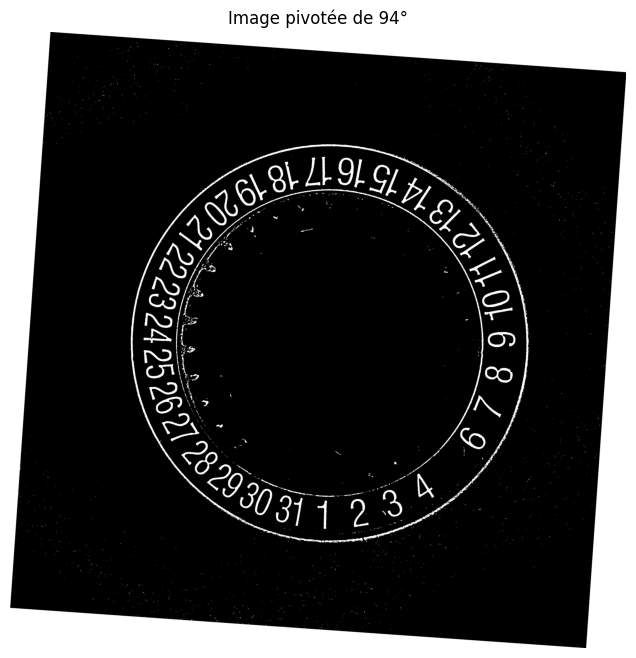

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image
image_path = "dataset_binarized/train/non_conformes/30mm_WonB_5_resized_copy1_copy1_copy1.jpg"
image = cv2.imread(image_path)

# Vérifier que l'image est bien chargée
if image is None:
    print("Erreur : image introuvable.")
else:
    # Obtenir les dimensions de l'image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Créer la matrice de rotation (angle horaire = -94°)
    angle = -94  # vers la droite
    scale = 1.0
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

    # Calculer la nouvelle taille
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adapter la matrice pour centrer l'image pivotée
    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]

    # Appliquer la rotation
    rotated = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), borderValue=(255, 255, 255))

    # Convertir BGR -> RGB pour matplotlib
    rotated_rgb = cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)

    # Afficher avec matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(rotated_rgb)
    plt.title("Image pivotée de 94°")
    plt.axis("off")
    plt.show()


In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

def rotate_image(image, angle=-94):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]

    rotated = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), borderValue=(255, 255, 255))
    return rotated

def process_folder(source_dir, dest_dir, show=False):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            src_path = os.path.join(source_dir, filename)
            dst_path = os.path.join(dest_dir, filename)

            image = cv2.imread(src_path)
            if image is None:
                print(f"Erreur de lecture : {src_path}")
                continue

            rotated = rotate_image(image)

            # Sauvegarde de l'image pivotée
            cv2.imwrite(dst_path, rotated)
            print(f"Image enregistrée : {dst_path}")

            # Optionnel : affichage (1 seule fois par image)
            if show:
                rotated_rgb = cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)
                plt.imshow(rotated_rgb)
                plt.title(f"Pivotée: {filename}")
                plt.axis("off")
                plt.show()

# Utilisation
source_folder = "dataset"
destination_folder = "image_rotated"
process_folder(source_folder, destination_folder, show=False)
